Práctica 6: Support Vector Machines
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---

In [1]:
import sklearn.svm as sm
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import codecs

import re
import nltk
import nltk.stem.porter

Kernel lineal
---
Carga de datos para la parte 1.

In [8]:
data = loadmat('ex6data1.mat')
X1 = data['X']
Y1 = data['y'] 
Y1 = Y1.ravel()

Funciones auxiliares para mostrar los datos y la frontera de decisión.

In [26]:
def pinta_puntos(X, Y):   
    pos = (Y == 1).ravel()
    neg = (Y == 0).ravel()
    plt.scatter(X[pos, 0], X[pos, 1], marker='+')
    plt.scatter(X[neg, 0], X[neg, 1], edgecolors='black', marker='o')

In [27]:
def pinta_frontera(X, Y, svm):
    x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x2 = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x1, x2 = np.meshgrid(x1, x2)
    
    prediction = svm.predict(np.array([x1.ravel(),x2.ravel()]).T).reshape(x1.shape)
    plt.contour(x1, x2, prediction)

Visualización de los datos iniciales.

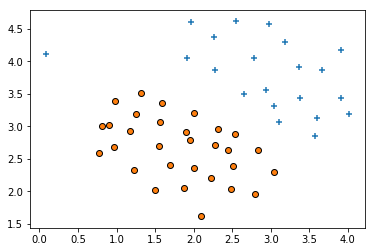

In [28]:
plt.figure()
pinta_puntos(X1, Y1)

Resultado del kernel linear con C = 1.

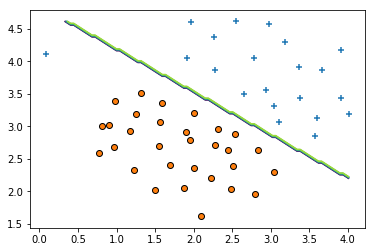

In [29]:
svm = sm.SVC(kernel='linear', C = 1)
svm.fit(X1,Y1)
plt.figure()
pinta_puntos(X1, Y1)
pinta_frontera(X1, Y1, svm)

Resultado del kernel linear con C = 100.

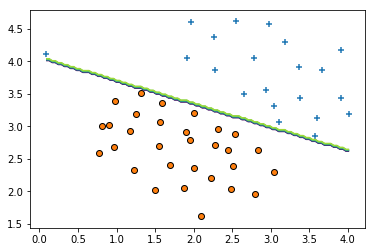

In [30]:
svm = sm.SVC(kernel='linear', C = 100)
svm.fit(X1,Y1)
plt.figure()
pinta_puntos(X1, Y1)
pinta_frontera(X1, Y1, svm)

Podemos comprobar que a mayor valor del parámetro C, más se ajusta la frontera de decisión a los datos de entrenamiento, llegando a provocar overfitting.

Kernel Gaussiano
---
Carga y visualización de datos.

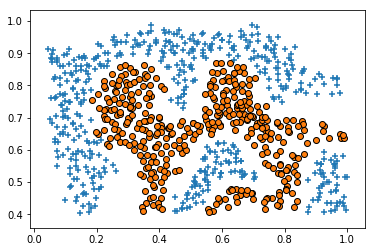

In [31]:
data = loadmat('ex6data2.mat')
X2 = data['X']
Y2 = data['y'] 
Y2 = Y2.ravel()
plt.figure()
pinta_puntos(X2, Y2)

Frontera de decisión con C = 1 y sigma = 0,1.

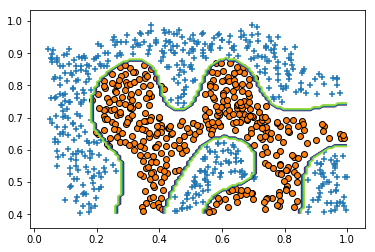

In [33]:
sigma = 0.1
svm = sm.SVC(kernel='rbf', C = 1, gamma = 1 / (2 * sigma**2))
svm.fit(X2,Y2)

plt.figure()
pinta_puntos(X2, Y2)
pinta_frontera(X2, Y2, svm)

Frontera de decisión con C = 100 y sigma = 0,1.

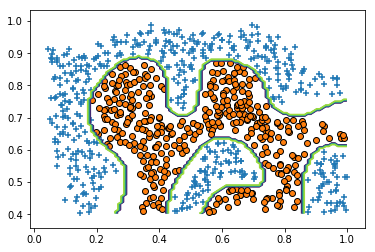

In [34]:
sigma = 0.1
svm = sm.SVC(kernel='rbf', C = 100, gamma = 1 / (2 * sigma**2))
svm.fit(X2,Y2)

plt.figure()
pinta_puntos(X2, Y2)
pinta_frontera(X2, Y2, svm)

El kernel gaussiano (o RBF modificado) se ajusta de forma no lineal a los datos, pintando una frontera bastante ajustada a los datos de por sí. Como podemos ver en el segundo ejemplo, al aumentar de nuevo el parámetro C, la frontera puede sufrir overfitting.

Parámetros C y sigma.
---
Carga y muestra de datos iniciales.

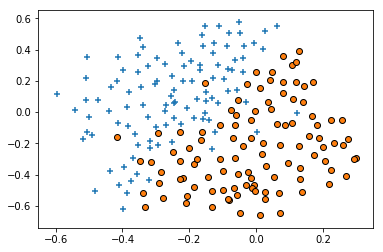

In [39]:
data = loadmat('ex6data3.mat')
X3 = data['X']
Y3 = data['y'] 
Y3 = Y3.ravel()
Xval3 = data['Xval']
Yval3 = data['yval']
Yval3 = Yval3.ravel()

plt.figure()
pinta_puntos(X3, Y3)

Con el fin de encontrar los mejores parámetros que se ajusten a los nuevos datos, probaremos a modificar los valores de C y sigma, utilizando el kernel gaussiano.

In [52]:
def train_model(X, Y, Xval, Yval):
    modelo = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    maxPredict = 0
    for i in modelo:
        for j in modelo:
            svm = sm.SVC(kernel='rbf', C = i, gamma = 1 / (2 * j**2))
            svm.fit(X,Y)

            prediction = np.sum((svm.predict(Xval) == Yval) * 1)
            percent = prediction / Yval.shape[0] * 100
            if percent > maxPredict:
                maxPredict = percent
                print("Nuevo máximo: ", percent, "con C = ", i, ", sigma = ", j)
    
train_model(X3, Y3, Xval3, Yval3)

Nuevo máximo:  43.5 con C =  0.01 , sigma =  0.01
Nuevo máximo:  45.0 con C =  0.03 , sigma =  0.1
Nuevo máximo:  86.0 con C =  0.03 , sigma =  0.3
Nuevo máximo:  94.5 con C =  0.1 , sigma =  0.1
Nuevo máximo:  96.0 con C =  0.3 , sigma =  0.1
Nuevo máximo:  96.5 con C =  1 , sigma =  0.1


Una vez conocemos los mejores valores (C = 1 y sigma = 0.1), podremos comprobar en la gráfica la frontera de decisión resultante.

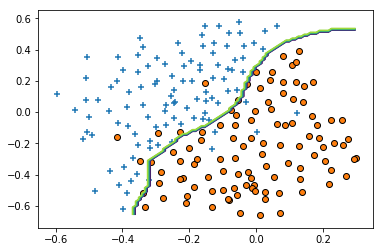

In [44]:
svm = sm.SVC(kernel='rbf', C = 1, gamma = 1 / (2 * 0.1**2))
svm.fit(X3,Y3)
plt.figure()
pinta_puntos(X3, Y3)
pinta_frontera(X3, Y3, svm)

Detección de spam
---
Carga de los ficheros .py proporcionados para la práctica.

In [48]:
# %load get_vocab_dict
def getVocabDict(reverse=False):
    """
    Function to read in the supplied vocab list text file into a dictionary.
    Dictionary key is the stemmed word, value is the index in the text file
    If "reverse", the keys and values are switched.
    """
    vocab_dict = {}
    with open("vocab.txt") as f:
        for line in f:
            (val, key) = line.split()
            if not reverse:
                vocab_dict[key] = int(val)
            else:
                vocab_dict[int(val)] = key

    return vocab_dict


In [49]:
# %load process_email.py
import re
import nltk
import nltk.stem.porter


def preProcess(email):
    
    hdrstart = email.find("\n\n")
    if hdrstart != -1:
        email = email[hdrstart:]

    email = email.lower()
    # Strip html tags. replace with a space
    email = re.sub('<[^<>]+>', ' ', email)
    # Any numbers get replaced with the string 'number'
    email = re.sub('[0-9]+', 'number', email)
    # Anything starting with http or https:// replaced with 'httpaddr'
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email)
    # Strings with "@" in the middle are considered emails --> 'emailaddr'
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email)
    # The '$' sign gets replaced with 'dollar'
    email = re.sub('[$]+', 'dollar', email)
    return email


def email2TokenList(raw_email):
    """
    Function that takes in a raw email, preprocesses it, tokenizes it,
    stems each word, and returns a list of tokens in the e-mail
    """

    stemmer = nltk.stem.porter.PorterStemmer()
    email = preProcess(raw_email)

    # Split the e-mail into individual words (tokens) 
    tokens = re.split('[ \@\$\/\#\.\-\:\&\*\+\=\[\]\?\!\(\)\{\}\,\'\"\>\_\<\;\%]',
                      email)

    # Loop over each token and use a stemmer to shorten it
    tokenlist = []
    for token in tokens:

        token = re.sub('[^a-zA-Z0-9]', '', token)
        stemmed = stemmer.stem(token)
        #Throw out empty tokens
        if not len(token):
            continue
        # Store a list of all unique stemmed words
        tokenlist.append(stemmed)

    return tokenlist


Funciones auxiliares para cargar todos los correos de un directorio y representarlos como una matriz de 0s y 1s en función de las palabras que contiene.

In [59]:
def multi_process(direc, num):   
    matriz = []
    for i in range(num):
        matriz.append(email_process(direc, i+1))
    return np.array(matriz)

In [60]:
def email_process(direc, num):   
    email_contents = codecs.open('{0}/{1:04d}.txt'.format(direc, num), 'r',encoding='utf-8', errors='ignore').read()
    email = email2TokenList(email_contents)
    
    vocab = getVocabDict()
    res = np.zeros((len(vocab)))    
    for i in range(len(email)):    
        if email[i] in vocab: 
            res[vocab[email[i]]-1] = 1 
    return res

Para probar la mejor forma de clasificar el total de los correos, necesitaremos utilizar el kernel rbf. Al no conocer unos valores de C y sigma que se ajusten mejor a nuestro problema, probaremos con los mismos valores de ejemplo del apartado anterior.

Para ello, necesitamos dividir los datos de forma que haya un porcentaje de ellos que se utilice como entrenamiento (train) y otro que se utilice como validación (val).

Esta función nos permite realizar pruebas y ver directamente su resultado en función del porcentaje de datos de entrenamiento.

In [84]:
def prueba_clasificacion(percent_train, spam, easy_ham, hard_ham):
    spam_train = spam[int(200 * percent_train):]
    easy_ham_train = easy_ham[int(100 * percent_train):]
    hard_ham_train = hard_ham[int(100 * percent_train):]
    
    spam_val = spam[:int(200 * percent_train)]
    easy_ham_val = easy_ham[:int(100 * percent_train)]
    hard_ham_val = hard_ham[:int(100 * percent_train)]
    
    X = np.concatenate((spam_train,easy_ham_train,hard_ham_train))
    Y = np.concatenate((np.ones((spam_train.shape[0],1)), np.zeros((easy_ham_train.shape[0],1)),np.zeros((hard_ham_train.shape[0],1))))   
    Y = Y.ravel()
    Xval = np.concatenate((spam_val,easy_ham_val,hard_ham_val))
    Yval = np.concatenate((np.ones((spam_val.shape[0],1)), np.zeros((easy_ham_val.shape[0],1)),np.zeros((hard_ham_val.shape[0],1))))
    Yval = Yval.ravel()
    train_model(X, Y, Xval, Yval)

Como primera prueba, probaremos con un 60% de datos de entrenamiento.

In [85]:
spam = multi_process("spam", 200)
easy_ham = multi_process("easy_ham", 100)
hard_ham = multi_process("hard_ham", 100)

prueba_clasificacion(0.6, spam, easy_ham, hard_ham)

Nuevo máximo:  50.83333333333333 con C =  0.01 , sigma =  0.01
Nuevo máximo:  51.24999999999999 con C =  0.01 , sigma =  0.03
Nuevo máximo:  51.66666666666667 con C =  0.01 , sigma =  0.1
Nuevo máximo:  67.91666666666667 con C =  0.01 , sigma =  0.3
Nuevo máximo:  72.08333333333333 con C =  0.01 , sigma =  10
Nuevo máximo:  79.58333333333333 con C =  0.3 , sigma =  10
Nuevo máximo:  89.16666666666667 con C =  1 , sigma =  10
Nuevo máximo:  95.41666666666667 con C =  3 , sigma =  10
Nuevo máximo:  95.83333333333334 con C =  10 , sigma =  10


Tras ver los resultados finales, hemos decidido realizar otra serie de pruebas, modificando sólo el porcentaje de entrenamiento.

In [86]:
prueba_clasificacion(0.7, spam, easy_ham, hard_ham)

Nuevo máximo:  51.07142857142857 con C =  0.01 , sigma =  0.01
Nuevo máximo:  51.42857142857142 con C =  0.01 , sigma =  0.03
Nuevo máximo:  51.78571428571429 con C =  0.01 , sigma =  0.1
Nuevo máximo:  62.142857142857146 con C =  0.01 , sigma =  0.3
Nuevo máximo:  72.85714285714285 con C =  0.01 , sigma =  10
Nuevo máximo:  76.42857142857142 con C =  0.3 , sigma =  10
Nuevo máximo:  86.07142857142858 con C =  1 , sigma =  10
Nuevo máximo:  91.78571428571428 con C =  3 , sigma =  10
Nuevo máximo:  92.14285714285714 con C =  10 , sigma =  10


In [87]:
prueba_clasificacion(0.4, spam, easy_ham, hard_ham)

Nuevo máximo:  50.0 con C =  0.01 , sigma =  0.01
Nuevo máximo:  61.875 con C =  0.01 , sigma =  1
Nuevo máximo:  73.75 con C =  0.01 , sigma =  10
Nuevo máximo:  82.5 con C =  0.3 , sigma =  10
Nuevo máximo:  94.375 con C =  1 , sigma =  10
Nuevo máximo:  96.875 con C =  3 , sigma =  10


In [90]:
prueba_clasificacion(0.1, spam, easy_ham, hard_ham)

Nuevo máximo:  50.0 con C =  0.01 , sigma =  0.01
Nuevo máximo:  52.5 con C =  0.01 , sigma =  0.03
Nuevo máximo:  67.5 con C =  0.01 , sigma =  1
Nuevo máximo:  72.5 con C =  0.1 , sigma =  10
Nuevo máximo:  82.5 con C =  0.3 , sigma =  10
Nuevo máximo:  85.0 con C =  1 , sigma =  3
Nuevo máximo:  100.0 con C =  1 , sigma =  10


Como podemos observar, cuanto menor es la cantidad de datos de entrenamiento, mayor es el porcentaje de aciertos durante la validación. 